In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import io
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from keras.utils import to_categorical
from keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
data = pd.read_csv('/content/gdrive/MyDrive/EMG/features_split.csv')
data

,Unnamed: 0,session,participant,gesture,index,iemg,mav,ssi,myopulse,wflen,...,kurtosis_f_w3,kurtosis_f_w4,kurtosis_f_w5,kurtosis_f_w6,kurtosis_f_w7,kurtosis_f_w8,kurtosis_f_w9,kurtosis_f_w10,kurtosis_f_w11,kurtosis_f_w12
0,0,1,1,10,0,11996.863087,0.041842,997.135823,6.224512,8143.485828,...,61.940683,116.130710,31.371157,107.176549,64.459302,241.232060,54.880235,56.951175,42.644289,118.918727
1,1,1,1,10,0,10550.150337,0.036796,1019.627142,6.443555,6646.721181,...,160.171639,87.566832,154.616093,280.595181,160.756112,98.589493,135.655396,194.396727,294.858908,537.374741
2,2,1,1,10,0,9230.366582,0.032193,630.013233,6.033789,6023.438546,...,195.666850,90.568034,94.299202,276.105575,101.698579,49.607516,150.348389,151.177847,156.860637,115.905382
3,3,1,1,10,0,15949.504704,0.055627,1995.234560,4.999609,9318.559036,...,33.886272,80.377706,46.373047,64.445165,31.711430,33.328942,50.491362,81.876212,69.070232,142.723324
4,4,1,1,10,0,15936.956936,0.055584,1830.412922,5.870117,10476.465579,...,48.630658,39.722917,25.079065,84.877336,29.229362,48.843301,44.917769,39.354396,78.705208,176.820713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15346,15346,3,9,9,0,7435.557234,0.025933,369.818221,6.280762,5792.222983,...,29.589425,25.460694,182.962449,34.957161,18.846525,37.714119,26.569683,32.614845,12.793219,16.657922
15347,15347,3,9,9,0,10471.625678,0.036522,713.052200,6.967187,8628.380136,...,18.226247,35.715660,113.822913,64.223311,8.214120,39.211218,29.910432,26.426457,24.892159,82.241098
15348,15348,3,9,9,0,11279.138159,0.039339,815.440185,6.917773,9229.795138,...,15.486525,29.417342,25.153035,19.632020,15.590478,15.462391,34.940941,37.564280,14.208021,15.811267
15349,15349,3,9,9,0,9210.946156,0.032125,563.422838,7.359570,8040.357766,...,14.527208,20.281059,20.418717,18.471741,14.276295,10.083487,27.337412,12.804675,20.220452,37.494222


In [4]:
df = data.drop(['Unnamed: 0', 'index'], axis = 1)
df.head()

,session,participant,gesture,iemg,mav,ssi,myopulse,wflen,diffvar,dasd,...,kurtosis_f_w3,kurtosis_f_w4,kurtosis_f_w5,kurtosis_f_w6,kurtosis_f_w7,kurtosis_f_w8,kurtosis_f_w9,kurtosis_f_w10,kurtosis_f_w11,kurtosis_f_w12
0,1,1,10,11996.863087,0.041842,997.135823,6.224512,8143.485828,0.001888,0.034480,...,61.940683,116.130710,31.371157,107.176549,64.459302,241.232060,54.880235,56.951175,42.644289,118.918727
1,1,1,10,10550.150337,0.036796,1019.627142,6.443555,6646.721181,0.001438,0.030668,...,160.171639,87.566832,154.616093,280.595181,160.756112,98.589493,135.655396,194.396727,294.858908,537.374741
2,1,1,10,9230.366582,0.032193,630.013233,6.033789,6023.438546,0.001169,0.027090,...,195.666850,90.568034,94.299202,276.105575,101.698579,49.607516,150.348389,151.177847,156.860637,115.905382
3,1,1,10,15949.504704,0.055627,1995.234560,4.999609,9318.559036,0.003030,0.045251,...,33.886272,80.377706,46.373047,64.445165,31.711430,33.328942,50.491362,81.876212,69.070232,142.723324
4,1,1,10,15936.956936,0.055584,1830.412922,5.870117,10476.465579,0.003688,0.047223,...,48.630658,39.722917,25.079065,84.877336,29.229362,48.843301,44.917769,39.354396,78.705208,176.820713


In [5]:
df_session1 = df[df['session']==1].drop(['session'], axis=1)
df_session1

,participant,gesture,iemg,mav,ssi,myopulse,wflen,diffvar,dasd,willison,...,kurtosis_f_w3,kurtosis_f_w4,kurtosis_f_w5,kurtosis_f_w6,kurtosis_f_w7,kurtosis_f_w8,kurtosis_f_w9,kurtosis_f_w10,kurtosis_f_w11,kurtosis_f_w12
0,1,10,11996.863087,0.041842,997.135823,6.224512,8143.485828,0.001888,0.034480,10277,...,61.940683,116.130710,31.371157,107.176549,64.459302,241.232060,54.880235,56.951175,42.644289,118.918727
1,1,10,10550.150337,0.036796,1019.627142,6.443555,6646.721181,0.001438,0.030668,6420,...,160.171639,87.566832,154.616093,280.595181,160.756112,98.589493,135.655396,194.396727,294.858908,537.374741
2,1,10,9230.366582,0.032193,630.013233,6.033789,6023.438546,0.001169,0.027090,5052,...,195.666850,90.568034,94.299202,276.105575,101.698579,49.607516,150.348389,151.177847,156.860637,115.905382
3,1,10,15949.504704,0.055627,1995.234560,4.999609,9318.559036,0.003030,0.045251,19492,...,33.886272,80.377706,46.373047,64.445165,31.711430,33.328942,50.491362,81.876212,69.070232,142.723324
4,1,10,15936.956936,0.055584,1830.412922,5.870117,10476.465579,0.003688,0.047223,21471,...,48.630658,39.722917,25.079065,84.877336,29.229362,48.843301,44.917769,39.354396,78.705208,176.820713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,9,9,8330.506011,0.029054,570.377368,6.942090,6667.094393,0.001537,0.030580,8011,...,44.013751,56.379520,110.276549,134.382196,186.975452,21.307146,143.103797,85.481422,563.048372,1597.823111
5113,9,9,6125.800599,0.021365,257.372885,6.706738,4952.278656,0.000760,0.022171,2864,...,23.122260,45.919163,45.720303,34.231240,73.429730,130.601048,53.935145,28.191160,16.094368,24.678199
5114,9,9,8623.283357,0.030076,526.630565,6.875488,6835.927773,0.001354,0.030244,6632,...,25.678269,29.597225,34.054478,18.530336,25.734288,12.206696,28.335428,15.867880,20.778713,66.368247
5115,9,9,8611.490022,0.030034,549.513711,7.371973,7446.678774,0.001864,0.033306,10998,...,34.220093,62.341778,49.964907,48.179048,18.390340,18.786165,65.060838,42.554823,26.324820,48.369875


In [6]:
scaler = StandardScaler()

X = scaler.fit_transform(df_session1.iloc[0:,3:])
y = df_session1['gesture']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust 'n_estimators' as needed
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

# Additional metrics
report = classification_report(y_test, y_pred)
print(report)

Accuracy: 72.56%
              precision    recall  f1-score   support

           1       0.83      0.59      0.69        68
           2       0.51      0.63      0.56        60
           3       0.72      0.76      0.74        68
           4       0.69      0.46      0.55        74
           5       0.67      0.63      0.65        65
           6       0.70      0.77      0.74        56
           7       0.66      0.70      0.68        61
           8       0.69      0.71      0.70        59
           9       0.67      0.62      0.64        60
          10       0.80      0.66      0.72        71
          11       0.88      0.94      0.91        54
          12       0.88      0.83      0.85        59
          13       0.67      0.86      0.75        49
          14       0.90      0.88      0.89        69
          15       0.69      0.79      0.74        53
          16       0.44      0.55      0.49        38
          17       0.94      1.00      0.97        60

    accur

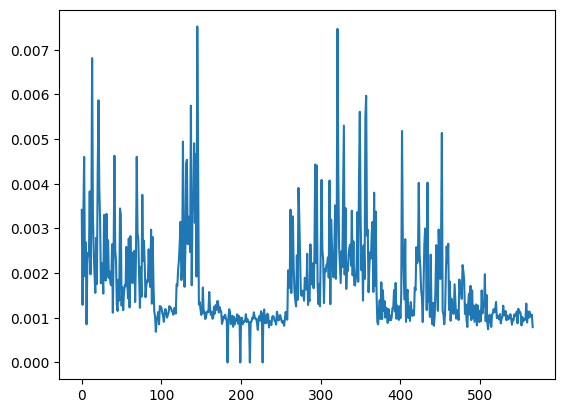

In [7]:
feature_importance = rf_model.feature_importances_
plt.plot(feature_importance)

In [8]:
scaler = StandardScaler()

X = scaler.fit_transform(df.iloc[0:,3:])
y = df['gesture']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

# Additional metrics
report = classification_report(y_test, y_pred)
print(report)

Accuracy: 76.03%
              precision    recall  f1-score   support

           1       0.70      0.50      0.58       196
           2       0.56      0.64      0.60       177
           3       0.68      0.80      0.73       178
           4       0.61      0.54      0.58       183
           5       0.75      0.69      0.71       175
           6       0.81      0.83      0.82       166
           7       0.68      0.67      0.67       189
           8       0.78      0.73      0.75       167
           9       0.67      0.70      0.68       165
          10       0.84      0.73      0.78       201
          11       0.92      0.95      0.94       191
          12       0.93      0.91      0.92       195
          13       0.79      0.87      0.83       178
          14       0.87      0.85      0.86       164
          15       0.76      0.86      0.81       191
          16       0.66      0.69      0.67       181
          17       0.91      0.98      0.95       174

    accur

In [9]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lr_model = LogisticRegression(max_iter=2000, random_state=42)

ensemble_model = VotingClassifier(estimators=[('rf', rf_model), ('lr', lr_model)], voting='soft')
ensemble_model.fit(X_train, y_train)

y_pred = ensemble_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')


report = classification_report(y_test, y_pred)
print(report)

Accuracy: 82.81%
              precision    recall  f1-score   support

           1       0.70      0.67      0.69       196
           2       0.70      0.72      0.71       177
           3       0.79      0.85      0.82       178
           4       0.72      0.69      0.70       183
           5       0.80      0.81      0.80       175
           6       0.86      0.89      0.88       166
           7       0.74      0.76      0.75       189
           8       0.87      0.86      0.86       167
           9       0.81      0.75      0.78       165
          10       0.90      0.82      0.86       201
          11       0.98      0.98      0.98       191
          12       0.90      0.92      0.91       195
          13       0.89      0.93      0.91       178
          14       0.87      0.88      0.88       164
          15       0.86      0.88      0.87       191
          16       0.75      0.69      0.72       181
          17       0.92      0.98      0.95       174

    accur

In [10]:
# df_session1['gesture']

0       10
1       10
2       10
3       10
4       10
        ..
5112     9
5113     9
5114     9
5115     9
5116     9
Name: gesture, Length: 5117, dtype: int64

In [11]:
# sequence_length = 10
# X = scaler.fit_transform(df_session1.iloc[0:,2:])


# X = []
# y = []

# for i in range(len(df_session1) - sequence_length):
#     X.append(df_session1.iloc[i:i+sequence_length, 2:])
#     y.append(df_session1.iloc[i+sequence_length, 1])

# X = np.array(X)
# y = np.array(y) - 1

# from keras.utils import to_categorical
# y = to_categorical(y)


In [12]:
# y.shape

#LSTM

In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(df_session1.iloc[0:,2:])
y = df_session1['gesture'] - 1

X = np.reshape(X, (X.shape[0],1,X.shape[1]))
y = to_categorical(y, num_classes = 17)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(1, 568),activation="relu",return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32,activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             162048    
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 17)                561       
                                                                 
Total params: 175025 (683.69 KB)
Trainable params: 175025 (683.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
128/128 [==============================] - 9s 13ms/step - loss: 2.6343 - accuracy: 0.1996 - val_loss: 2.3871 - val_accuracy: 0.3184
Epoch 2/100
128/128 [==============================] - 1s 10ms/step - loss: 2.2147 - accuracy: 0.3648 - val_loss: 2.0229 - val_accuracy: 0.4199
Epoch 3/100
128/128 [==============================] - 1s 10ms/step - loss: 1.8966 - accuracy: 0.4674 - val_loss: 1.7433 - val_accuracy: 0.5137
Epoch 4/100
128/128 [==============================] - 1s 10ms/step - loss: 1.6471 - accuracy: 0.5353 - val_loss: 1.5834 - val_accuracy: 0.5273
Epoch 5/100
128/128 [==============================] - 1s 10ms/step - loss: 1.4574 - accuracy: 0.5922 - val_loss: 1.3947 - val_accuracy: 0.6143
Epoch 6/100
128/128 [==============================] - 3s 23ms/step - loss: 1.3322 - accuracy: 0.6179 - val_loss: 1.2795 - val_accuracy: 0.6357
Epoch 7/100
128/128 [==============================] - 3s 25ms/step - loss: 1.2113 - accuracy: 0.6565 - val_loss: 1.1715 - val_accuracy:

In [15]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')

32/32 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.7900
Accuracy: 79.00%


In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(df.iloc[0:,3:])
y = df['gesture'] - 1

X = np.reshape(X, (X.shape[0],1,X.shape[1]))
y = to_categorical(y, num_classes = 17)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(1, 568),activation="relu",return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32,activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 64)             162048    
                                                                 
 dropout_2 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 17)                561       
                                                                 
Total params: 175025 (683.69 KB)
Trainable params: 175025 (683.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
384/384 [==============================] - 8s 15ms/step - loss: 2.3019 - accuracy: 0.3333 - val_loss: 1.7106 - val_accuracy: 0.5500
Epoch 2/100
384/384 [==============================] - 4s 10ms/step - loss: 1.5294 - accuracy: 0.5691 - val_loss: 1.2209 - val_accuracy: 0.6636
Epoch 3/100
384/384 [==============================] - 4s 9ms/step - loss: 1.2207 - accuracy: 0.6411 - val_loss: 1.0303 - val_accuracy: 0.6929
Epoch 4/100
384/384 [==============================] - 4s 12ms/step - loss: 1.0370 - accuracy: 0.6825 - val_loss: 0.8991 - val_accuracy: 0.7284
Epoch 5/100
384/384 [==============================] - 5s 12ms/step - loss: 0.9211 - accuracy: 0.7143 - val_loss: 0.8247 - val_accuracy: 0.7304
Epoch 6/100
384/384 [==============================] - 4s 9ms/step - loss: 0.8446 - accuracy: 0.7328 - val_loss: 0.7528 - val_accuracy: 0.7538
Epoch 7/100
384/384 [==============================] - 4s 9ms/step - loss: 0.7752 - accuracy: 0.7564 - val_loss: 0.7152 - val_accuracy: 0.

In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')

96/96 [==============================] - 0s 4ms/step - loss: 0.5377 - accuracy: 0.8199
Accuracy: 81.99%


#LSTM Sequences(RNN)

In [19]:
data = pd.read_csv('/content/gdrive/MyDrive/EMG/features_split.csv')
df = data.drop(['Unnamed: 0', 'index'], axis = 1)
df_session1 = df[df['session']==1].drop(['session'], axis=1)

In [20]:
scaler = StandardScaler()
df_session1.iloc[0:,2:] = scaler.fit_transform(df_session1.iloc[0:,2:])

X = []
y = []

sequence_length = 10
for i in range(len(df_session1) - sequence_length):
    X.append(df_session1.iloc[i:i+sequence_length, 2:])
    y.append(df_session1.iloc[i+sequence_length, 1])

X = np.array(X)
y = np.array(y) - 1
y = to_categorical(y, num_classes = 17)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1],X.shape[2]),activation="relu",return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32,activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(17, activation='sigmoid'))
from keras.optimizers import SGD
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 64)            162048    
                                                                 
 dropout_4 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 17)                561       
                                                                 
Total params: 175025 (683.69 KB)
Trainable params: 175025 (683.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
128/128 [==============================] - 9s 51ms/step - loss: 2.4775 - accuracy: 0.2619 - val_loss: 1.9953 - val_accuracy: 0.4628
Epoch 2/100
128/128 [==============================] - 6s 46ms/step - loss: 1.7769 - accuracy: 0.5097 - val_loss: 1.3747 - val_accuracy: 0.6526
Epoch 3/100
128/128 [==============================] - 5s 39ms/step - loss: 1.3098 - accuracy: 0.6634 - val_loss: 1.0077 - val_accuracy: 0.7466
Epoch 4/100
128/128 [==============================] - 7s 56ms/step - loss: 0.9960 - accuracy: 0.7469 - val_loss: 0.8324 - val_accuracy: 0.7789
Epoch 5/100
128/128 [==============================] - 5s 40ms/step - loss: 0.8456 - accuracy: 0.7812 - val_loss: 0.6436 - val_accuracy: 0.8053
Epoch 6/100
128/128 [==============================] - 7s 57ms/step - loss: 0.7016 - accuracy: 0.8149 - val_loss: 0.5877 - val_accuracy: 0.8180
Epoch 7/100
128/128 [==============================] - 5s 41ms/step - loss: 0.6274 - accuracy: 0.8306 - val_loss: 0.7251 - val_accuracy:

In [22]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')

32/32 [==============================] - 0s 6ms/step - loss: 0.3892 - accuracy: 0.8728
Accuracy: 87.28%


In [23]:
data = pd.read_csv('/content/gdrive/MyDrive/EMG/features_split.csv')
df = data.drop(['Unnamed: 0', 'index'], axis = 1)
df_session1 = df[df['session']==1].drop(['session'], axis=1)

In [24]:
scaler = StandardScaler()
df.iloc[0:,3:] = scaler.fit_transform(df.iloc[0:,3:])

X = []
y = []

sequence_length = 10
for i in range(len(df) - sequence_length):
    X.append(df.iloc[i:i+sequence_length, 3:])
    y.append(df.iloc[i+sequence_length, 2])

X = np.array(X)
y = np.array(y) - 1
y = to_categorical(y, num_classes = 17)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1],X.shape[2]),activation="relu",return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32,activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(17, activation='sigmoid'))
from keras.optimizers import SGD
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 64)            162048    
                                                                 
 dropout_6 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 17)                561       
                                                                 
Total params: 175025 (683.69 KB)
Trainable params: 175025 (683.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
y.shape

(15341, 17)

In [26]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
384/384 [==============================] - 22s 48ms/step - loss: 1.9877 - accuracy: 0.4183 - val_loss: 1.1156 - val_accuracy: 0.7208
Epoch 2/100
384/384 [==============================] - 17s 44ms/step - loss: 0.9965 - accuracy: 0.7339 - val_loss: 0.6597 - val_accuracy: 0.8065
Epoch 3/100
384/384 [==============================] - 17s 43ms/step - loss: 0.6781 - accuracy: 0.8115 - val_loss: 0.5791 - val_accuracy: 0.8133
Epoch 4/100
384/384 [==============================] - 17s 45ms/step - loss: 0.5726 - accuracy: 0.8277 - val_loss: 0.5030 - val_accuracy: 0.8322
Epoch 5/100
384/384 [==============================] - 18s 47ms/step - loss: 0.4587 - accuracy: 0.8591 - val_loss: 0.5210 - val_accuracy: 0.8276
Epoch 6/100
384/384 [==============================] - 17s 44ms/step - loss: 0.4502 - accuracy: 0.8607 - val_loss: 0.3642 - val_accuracy: 0.8638
Epoch 7/100
384/384 [==============================] - 17s 43ms/step - loss: 0.3810 - accuracy: 0.8795 - val_loss: 0.3323 - val_ac

In [27]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')

96/96 [==============================] - 1s 6ms/step - loss: 0.3068 - accuracy: 0.8837
Accuracy: 88.37%
